# User Retention Analysis
In the competitive world of digital business, understanding user behavior and loyalty is no longer an option, but a necessity. One of the most effective methods for gaining insights into user loyalty is through cohort retention analysis, a technique that groups users based on when they first interacted with a product or service—and then tracks how long they remain active over time.

This analysis helps companies see detailed retention patterns: whether users remain loyal after the first month, when the majority begin to churn, and how marketing strategies or product changes impact user loyalty over a specific period. By organizing retention data into a cohort heatmap, we can easily identify user attrition trends, identify critical churn points, and compare cohort performance over time.

With this comprehensive understanding, companies can design more targeted retention strategies, increase customer lifetime value, and ultimately strengthen sustainable business growth.

# Impor packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# Import data from CSV to DataFrame

In [2]:
df = pd.read_csv('C:/Users/LENOVO/Python/Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data preprocessing

In [4]:
df_clean = df.copy()

## Convert the order_date column to datetime
Because we want to analyze time patterns (such as monthly trends), the order_date column needs to be converted to a time format (datetime) so that it can be processed temporally.

In [5]:
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

## create year_month column
A new year_month column is created to store the month and year information for each order. This is useful for aggregating data by month.

In [6]:
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

## delete all rows without a customer_id
Without a customer_id, we can't track who made a purchase. Therefore, these rows are deleted.

In [7]:
df_clean = df_clean[~df_clean['customer_id'].isna()]

## delete all rows without product_name
Data without product_name is not informative, so it is removed to maintain data quality.

In [8]:
df_clean = df_clean[~df_clean['product_name'].isna()]

## make all product_names lowercase
To standardize formatting and avoid duplication (e.g., "Coffee" vs. "coffee"), all product names are converted to lowercase.

In [9]:
df_clean['product_name'] = df_clean['product_name'].str.lower()

## delete all rows with product_code or product_name test
Products containing the word “test” or having a specific product_code for testing are deleted, as they are not part of the real data.

In [10]:
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

## Create an order_status column with the value 'cancelled' if the order_id begins with the letter 'c' and 'delivered' if the order_id does not begin with the letter 'c'.
Based on the pattern in the order_id, an order_status column is created to distinguish between canceled orders (if the order_id begins with the letter 'c') and successfully delivered orders.

In [11]:
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

## Change the negative quantity value to a positive one, as this only indicates that the order is cancelled.
Since a negative value only indicates a cancelled status, it is changed to a positive one so that it can still be calculated correctly during analysis.

In [12]:
df_clean['quantity'] = df_clean['quantity'].abs()

## delete rows with negative price values
Prices cannot be negative in actual transactions, so these rows are considered errors and are deleted.

In [13]:
df_clean = df_clean[df_clean['price']>0]

## Create an amount value, which is the multiplication of quantity and price.
Then, create an amount column using the simple formula: quantity × price. This will be used to analyze the value of purchases.

In [14]:
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

## replaces the product_name of a product_code that has multiple product_names with the one that appears most frequently.
For consistency, use the single most frequently occurring product name for each product_code.

In [15]:
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(
    order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby(
    'product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(
    columns=['order_cnt','rank'])

In [16]:
df_clean = df_clean.merge(most_freq_product_name.rename(
    columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

## convert customer_id to string
Because the ID only serves as a unique identifier, not a calculated number, it is converted to a text type (string).

In [17]:
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

## remove outliers
Outlier data is removed to prevent it from affecting the overall analysis results.

In [18]:
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12,delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12,delivered,9.90


In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      358469 non-null  object        
 1   product_code  358469 non-null  object        
 2   product_name  358469 non-null  object        
 3   quantity      358469 non-null  int64         
 4   order_date    358469 non-null  datetime64[ns]
 5   price         358469 non-null  float64       
 6   customer_id   358469 non-null  object        
 7   year_month    358469 non-null  period[M]     
 8   order_status  358469 non-null  object        
 9   amount        358469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 27.3+ MB


# Creating a user retention cohort

## Aggregate transaction data into a summary of total transactions/orders per user each month
We want to see user behavior over time. Therefore, transaction data is first summarized into total transactions or the number of orders per user per month. This forms the basis for forming cohorts.

In [20]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12039,18286.0,2010-06,1
12040,18286.0,2010-08,1
12041,18287.0,2010-05,1
12042,18287.0,2010-09,2


## Create a column for a user cohort, for example, the first month of a transaction.
You need to know when a user first made a transaction. To do this, create a cohort column that indicates the month the user made their first transaction. This will be the initial group of users for retention analysis.

In [21]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12039,18286.0,2010-06,1,2010-06
12040,18286.0,2010-08,1,2010-06
12041,18287.0,2010-05,1,2010-05
12042,18287.0,2010-09,2,2010-05


Some notes:
* User ID 12346 made their first transaction in January 2010 (2010-01). Therefore, in all rows related to that user, the cohort column is 2010-01, even though their transactions occurred in subsequent months.
* User ID 18287 was first active in May 2010, so their cohort is 2010-05 for all their transactions.
* The cohort column is very important in cohort analysis because:
- It allows us to group users based on their first month of joining (transacting).
- We can track user retention over time, for example: how many of the 2010-01 cohort are still active in months 2, 3, and so on.
- This is the basis for creating a retention matrix.

## Calculate the number of months between the transaction month and the month of the first transaction and add it to 1 to make the month 0 equal to 1, meaning the first month, etc.
We want to know how many months have passed since the user's first transaction. So, calculate the difference in months between the transaction month and the cohort month and add 1. This way, the first month is given the number 1 instead of 0 for easier reading.

In [22]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


Some notes:
* User 12346 made their first transaction in January 2010, so:
    - 2010-01 → 1st month since joining → period_num = 1
    - 2010-03 → 3rd month since joining → period_num = 3
    - etc.
* The period_num column is very important in retention analysis because:
    - It helps us track user activity per month after they first joined.
    - It is used to create a retention pivot table, where the X-axis is period_num (month n), and the Y-axis is the cohort.

## Pivot table with index as cohort, column as month interval, and value as unique user count (unique user ID).
To facilitate retention pattern analysis, the data is created in a pivot table. The row (index) represents the month cohort, the column represents the month interval from the first transaction, and the value represents the number of unique users still active in that month.

In [23]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,528.0,146.0,158.0,145.0,140.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some notes:
* Provides an overview of how long users stay after first using the service.
* Used to calculate the retention rate (the percentage of active users out of the total cohort).
* Serves as the basis for creating retention heatmap visualizations, which are very common in business analysis or product analytics.
* Cohort 2010-01 → There were 713 users who first became active in January 2010.
    - Of this cohort, 280 were still active in the second month (February), 334 were active in the third month (March), and so on.
* Cohort 2010-02 → There were 461 new users in February 2010.
    - In the second month (March), 154 of them were still active, and so on.
* NaN (blank) means there is no data for that month because the analysis time has not reached that far (e.g.: the 2010-12 cohort does not have a 2nd month because there is no data for January 2011).

## Calculate the number of users in each cohort (users who made their first transaction in that month) and divide all values in the pivot table by that value to determine the retention rate.
The number of users in the first month serves as the reference for calculating retention. Each value in the pivot table is divided by the number of users in the first month (cohort size), resulting in the percentage of users who retain each month.

In [24]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2010-01    713.0
2010-02    461.0
2010-03    528.0
2010-04    326.0
2010-05    274.0
2010-06    266.0
2010-07    179.0
2010-08    160.0
2010-09    227.0
2010-10    362.0
2010-11    327.0
2010-12     66.0
Freq: M, Name: 1, dtype: float64

Some notes:
* Each number represents the number of unique customers who made their first purchase that month. These values are referred to as the cohort size.
* For example:
    - 713 customers made their first purchase in January 2010.
    - 461 customers made their first purchase in February 2010, and so on.
* This number will be the primary divisor when calculating the retention percentage for subsequent months (periods 2, 3, etc.).

In [25]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Display the pivot table containing the retention rate values in a heatmap.
To clearly visualize retention patterns, the results are visualized in a heatmap. This heatmap shows how retention rates change from month to month for each user cohort.

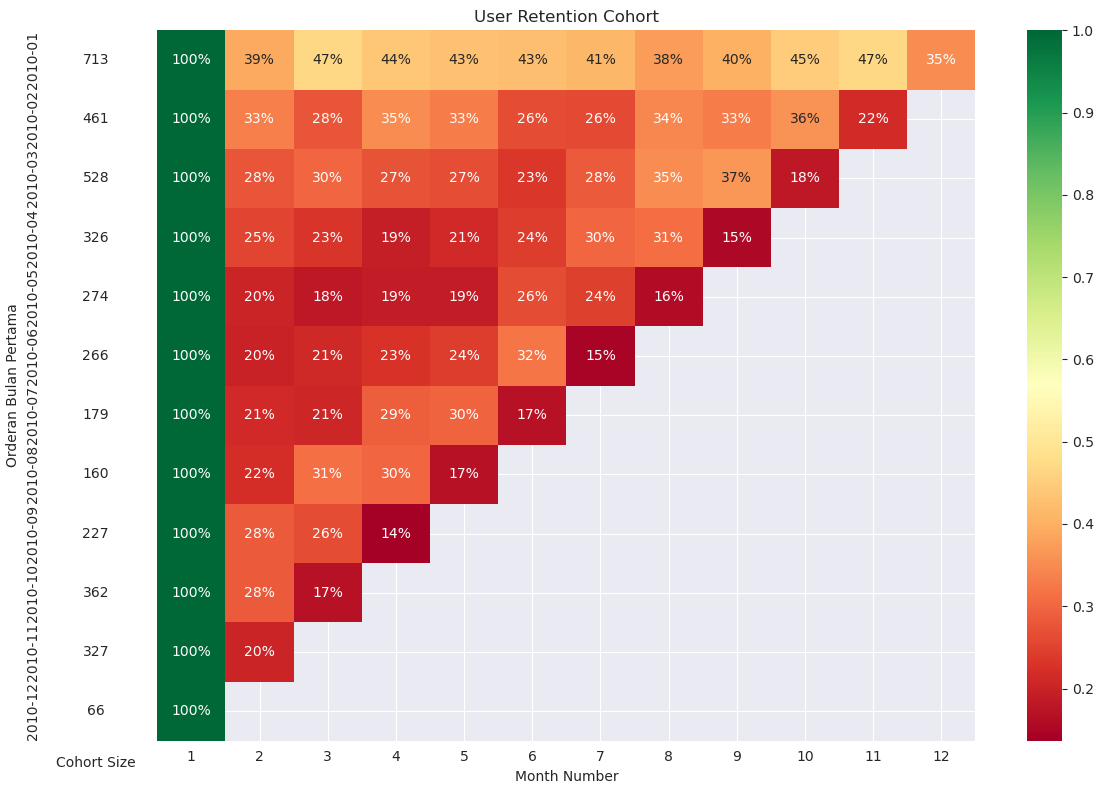

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('darkgrid'):

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='Orderan Bulan Pertama', xticklabels=[])

    fig.tight_layout()

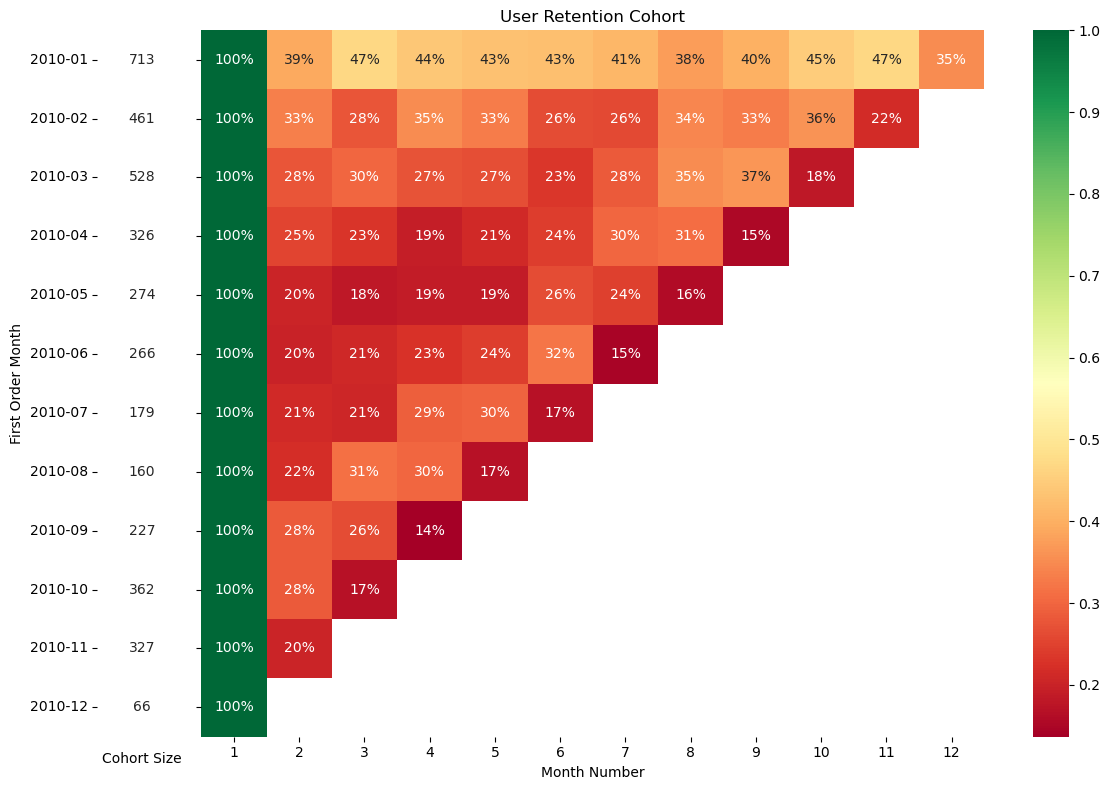

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})
# user retention cohort
sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('User Retention Cohort')
ax[1].set(xlabel='Month Number', ylabel='')
# cohort size
df_cohort_size = pd.DataFrame(cohort_size)
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
ax[0].tick_params(bottom=False)
ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])
fig.tight_layout()

Some notes:
* General trends
    - All cohorts showed 100% retention in month 1, which is understandable because the cohort definition starts with the first user ordering → 100% of users are definitely active in the first month.
    - From month 2 to month 12, retention percentages decreased in almost all cohorts. This pattern was consistent across each cohort: retention dropped sharply in the first 2–3 months, then stabilized at a low level.
* Cohorts with Better Retention
    - The January 2010 cohort (2010-01) stands out: its retention remained relatively high until month 12 (for example, month 12 retention was still 35%).
    - Conversely, cohorts in the middle and end of the year (e.g., June–December 2010) saw retention decline more rapidly and not sustainably (for example, the 2010-06 cohort had dropped to 15% by month 7).
* Key Insights
    - High user churn early on → most users are lost within the first 2–4 months.
    - Some early cohorts (Jan–Mar) have better retention than later cohorts (May–Dec).
    - Declining retention from cohort to cohort (from top to bottom) could indicate a problem:
        * Changes in product, pricing, service, or marketing after March/April that make users less loyal.
        * Or external changes (new competitors, market trends, etc.).

# Thank You